## Intro

This notebook seeks to answer the question:

Is the perception of traditional top tier countries (Japan, France, Turkey, Azerbaijan, Iran and Egypt) a correct one? If not, which are?"

This will be done using the WKF rankings database which contains all the known results of WKF ranking events

## Imports

Standard imports for doing data analysis.

In [1]:
import pandas as pd
import chardet
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Data inspection and import

In [2]:
!ls 'data'

wkf_rankings.csv


In [3]:
chardet.detect(open('data/wkf_rankings.csv', 'rb').read())

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}

In [4]:
rankings = 'data/wkf_rankings.csv'
rankings_df = pd.read_csv(rankings)
rankings_df

,_id,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
0,605db8673116015f78d72d62,AFG,AFG2082,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, ...",Continental Championship,Male Kumite -55 Kg,6.0,Participation,0.0,30.0
1,605db86c3116015f78d72d63,AFG,AFG02157,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, ...",Continental Championship,Male Kumite 84+ kg,6.0,Participation,2.0,150.0
2,605db8713116015f78d72d64,AFG,AFG2002,2015-09-05,Karate1 Premier League - Istanbul 2015 (TUR),Karate1 Premier League,Male Kumite -60 Kg,4.0,Participation,1.0,48.0
3,605db8773116015f78d72d65,AFG,AFG02158,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, ...",Continental Championship,Male Kumite -84 kg,6.0,Participation,0.0,30.0
4,605db87c3116015f78d72d66,AFG,AFG114,2012-11-21,21st World Seniors Karate Championships (FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...
119803,6065e6c1ba17128bc1cdac82,ZIM,ZIM02080,2019-07-12,UFAK Junior & Senior Championships - Gaborone...,Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
119804,6065e6c1ba17128bc1cdac82,ZIM,ZIM02080,2018-08-31,UFAK Junior & Senior Championships 2018 (RWA),Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
119805,6065e6c6ba17128bc1cdac83,ZIM,ZIM2009,2019-07-12,UFAK Junior & Senior Championships - Gaborone...,Continental Championship,Junior Kumite Female -48 kg,6.0,Participation,0.0,30.0
119806,6065e6ccba17128bc1cdac84,ZIM,ZIM2008,2018-05-29,TRANSITION POINTS_ZIM2008 (ZIM),Others,Male Kumite -60 Kg,1.0,Participation,0.0,30.0


In [5]:
list(rankings_df.columns)

['_id',
 'ranking_country',
 'ranking_competitor',
 'date',
 'event',
 'type',
 'category',
 'event_factor',
 'rank',
 'matches_won',
 'points']

In [6]:
rankings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119808 entries, 0 to 119807
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   _id                 119808 non-null  object 
 1   ranking_country     119808 non-null  object 
 2   ranking_competitor  119808 non-null  object 
 3   date                119808 non-null  object 
 4   event               119808 non-null  object 
 5   type                119808 non-null  object 
 6   category            119808 non-null  object 
 7   event_factor        119808 non-null  float64
 8   rank                119808 non-null  object 
 9   matches_won         119808 non-null  float64
 10  points              119808 non-null  float64
dtypes: float64(3), object(8)
memory usage: 10.1+ MB


The column names show the 'id' from the mongoDB import so this can be dropped and ignored.

'ranking_country' identifies the competitors country using Alpha-3-code <br>
'ranking_competitor' is a unique idetentifier given to each competitor only for the WKF rankings database <br>
'date' is the date of the event, currently in string format.  Will be converted later.<br>
'event' is the name of the competitive event.<br>
'type' is the type of event such as international championships, continental or world championships.<br>
'category' denotes the sex and weight of the competition entry.<br>
'event_factor' is a method of categorising the skill level of each event, also used as a multiplier for points scored.<br>
'rank' is the result of the competition. 'Partitipation' being an early round elimination and '1st Place' indicating winning the category for example.<br>
'matches_won' is the matches won by the competitor in reaching the rank.<br>
'points' is the WKF rankings points rewarded by mulitplying the result by the event factor. This is discounted as unrealable as some competitors have manual additions due to weight category changes or changing ranking country.<br>

Getting rid of excess id category

In [7]:
rankings_df.drop('_id', axis=1, inplace=True)

Converting to date-time

In [8]:
rankings_df['date']= pd.to_datetime(rankings_df['date'])

In [9]:
rankings_df.head()

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
0,AFG,AFG2082,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, ...",Continental Championship,Male Kumite -55 Kg,6.0,Participation,0.0,30.0
1,AFG,AFG02157,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, ...",Continental Championship,Male Kumite 84+ kg,6.0,Participation,2.0,150.0
2,AFG,AFG2002,2015-09-05,Karate1 Premier League - Istanbul 2015 (TUR),Karate1 Premier League,Male Kumite -60 Kg,4.0,Participation,1.0,48.0
3,AFG,AFG02158,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, ...",Continental Championship,Male Kumite -84 kg,6.0,Participation,0.0,30.0
4,AFG,AFG114,2012-11-21,21st World Seniors Karate Championships (FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0


In [10]:
rankings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119808 entries, 0 to 119807
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ranking_country     119808 non-null  object        
 1   ranking_competitor  119808 non-null  object        
 2   date                119808 non-null  datetime64[ns]
 3   event               119808 non-null  object        
 4   type                119808 non-null  object        
 5   category            119808 non-null  object        
 6   event_factor        119808 non-null  float64       
 7   rank                119808 non-null  object        
 8   matches_won         119808 non-null  float64       
 9   points              119808 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 9.1+ MB


## Dropping the data after world pandemic travel restrictions

On March 11th 2020 a global pandemic was declared by the World Health Organisation (WHO) in light of the spread of the COVID-19 coronavirus. This subsequently caused many countries to impose travel restrictions and cancel events to prevent the spread.

As a result of this, data from events AFTER March 11 2020 will be removed as it cannot be gaurenteed that it is consistent with the rest of the data from periods with no travel restrictions and athletes not having the same preperation and training facilities.

In [11]:
rankings_df = rankings_df[rankings_df['date'] <= '2020-03-11']

And check

In [12]:
rankings_df[rankings_df['date'] > '2020-03-11']

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points


## Getting rid of whitespace values

In [13]:
rankings_df.replace(u'\xa0',u'', regex=True, inplace=True)

/home/ross/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


## Getting to the question

Firstly we should consider what measure we want to use as "top tier". Could be best performing per type of event factor? Could we look at Karate1 events or are they in their own bubble?

We should first look at each unique type of event factor

In [14]:
rankings_df.event_factor.unique()

array([ 6.,  4., 12.,  3.,  5.,  1.,  2.,  7.])

Not heard of 7 rated event factor before, lets have a look.

In [15]:
rankings_df.loc[rankings_df['event_factor'] == 7.0]

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
342,ALG,ALG2390,2013-10-18,Sportaccord World Combat Games 2013(RUS),Invitational Championship,Female Kumite 68+ kg,7.0,2nd Place,2.0,490.0
1276,ARG,ARG110,2013-10-18,Sportaccord World Combat Games 2013(RUS),Invitational Championship,Male Kumite -75 Kg,7.0,5th Place,2.0,280.0
2041,AUS,AUS136,2013-10-18,Sportaccord World Combat Games 2013(RUS),Invitational Championship,Female Kumite -50 Kg,7.0,5th Place,0.0,168.0
2460,AUS,AUS172,2013-10-18,Sportaccord World Combat Games 2013(RUS),Invitational Championship,Female Kata,7.0,5th Place,0.0,168.0
2658,AUS,AUS118,2013-10-18,Sportaccord World Combat Games 2013(RUS),Invitational Championship,Female Kumite -61 kg,7.0,2nd Place,3.0,546.0
...,...,...,...,...,...,...,...,...,...,...
116285,USA,USA183,2013-10-18,Sportaccord World Combat Games 2013(RUS),Invitational Championship,Female Kumite -68 kg,7.0,3rd Place,3.0,406.0
116699,USA,USA173,2013-10-18,Sportaccord World Combat Games 2013(RUS),Invitational Championship,Male Kumite -75 Kg,7.0,4th Place,2.0,315.0
117298,URU,URU103,2013-10-18,Sportaccord World Combat Games 2013(RUS),Invitational Championship,Male Kumite -60 Kg,7.0,5th Place,1.0,224.0
118102,VEN,VEN113,2013-10-18,Sportaccord World Combat Games 2013(RUS),Invitational Championship,Male Kata,7.0,1st Place,5.0,798.0


Invite only compitition that was held 8 years ago and had an unusual structure. Won't be including these.

In [16]:
rankings_df.loc[rankings_df['event_factor'] == 12]

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
4,AFG,AFG114,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
7,AFG,AFG112,2008-11-13,19th World Senior Karate Championships(JPN),World Championship,Male Kumite -60 Kg,12.0,Participation,0.0,48.0
8,AFG,AFG109,2007-10-19,5th World Junior & Cadet Karate Championships(...,World Championship,Cadet -60 Kg (Male),12.0,Participation,0.0,48.0
9,AFG,AFG111,2008-11-13,19th World Senior Karate Championships(JPN),World Championship,Male Kumite -75 Kg,12.0,Participation,0.0,48.0
13,AFG,AFG108,2007-10-19,5th World Junior & Cadet Karate Championships(...,World Championship,Junior -65 Kg (Male),12.0,Participation,0.0,48.0
...,...,...,...,...,...,...,...,...,...,...
119790,ZIM,ZIM005,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Male Kumite -67 kg,12.0,Participation,0.0,60.0
119796,ZIM,ZIM005,2016-10-26,WKF World Senior Championships 2016(AUT),World Championship,Male Kumite -67 kg,12.0,Participation,0.0,60.0
119801,ZIM,ZIM005,2014-11-05,WKF World Senior Championships 2014(GER),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
119802,ZIM,ZIM005,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0


Create DataFrame only containing event factor events that match.

In [17]:
df_EF_12 = rankings_df[rankings_df['event_factor'] == 12]

In [18]:
df_EF_12.head()

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
4,AFG,AFG114,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
7,AFG,AFG112,2008-11-13,19th World Senior Karate Championships(JPN),World Championship,Male Kumite -60 Kg,12.0,Participation,0.0,48.0
8,AFG,AFG109,2007-10-19,5th World Junior & Cadet Karate Championships(...,World Championship,Cadet -60 Kg (Male),12.0,Participation,0.0,48.0
9,AFG,AFG111,2008-11-13,19th World Senior Karate Championships(JPN),World Championship,Male Kumite -75 Kg,12.0,Participation,0.0,48.0
13,AFG,AFG108,2007-10-19,5th World Junior & Cadet Karate Championships(...,World Championship,Junior -65 Kg (Male),12.0,Participation,0.0,48.0


In [19]:
df_EF_12['type'].unique()

array(['World Championship'], dtype=object)

In [20]:
df_EF_6 = rankings_df[rankings_df['event_factor'] == 6]
df_EF_6.head()

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
0,AFG,AFG2082,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -55 Kg,6.0,Participation,0.0,30.0
1,AFG,AFG02157,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite 84+ kg,6.0,Participation,2.0,150.0
3,AFG,AFG02158,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -84 kg,6.0,Participation,0.0,30.0
12,AFG,AFG02159,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Female Kumite -61 kg,6.0,7th Place,0.0,150.0
16,AFG,AFG02160,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -60 Kg,6.0,Participation,0.0,30.0


In [21]:
df_EF_6['type'].unique()

array(['Continental Championship', 'Karate1 Premier League'], dtype=object)

In [22]:
df_EF_5 = rankings_df[rankings_df['event_factor'] == 5]
df_EF_5['type'].unique()

array(['Karate1 Premier League'], dtype=object)

In [23]:
df_EF_4 = rankings_df[rankings_df['event_factor'] == 4]
df_EF_4['type'].unique()

array(['Karate1 Premier League', 'Mediterranean Games',
       'Continental Championship'], dtype=object)

In [24]:
df_EF_3 = rankings_df[rankings_df['event_factor'] == 3]
df_EF_3['type'].unique()

array(['Karate1 Series A', 'Karate1 Youth League', 'Karate1 World Cup',
       'Karate1 Premier League'], dtype=object)

In [25]:
df_EF_2 = rankings_df[rankings_df['event_factor'] == 2]
df_EF_2['type'].unique()

array(['WKF Accredited Competition', 'Karate1 Youth League',
       'Karate1 World Cup'], dtype=object)

In [26]:
df_EF_1 = rankings_df[rankings_df['event_factor'] == 1]
df_EF_1['type'].unique()

array(['Others', 'WKF Accredited Competition'], dtype=object)

Event factor 12 events are World Championships so focus on them.

## Working on Event Factor 12 events

In [27]:
df_EF_12.describe()

,event_factor,matches_won,points
count,17136.0,17136.000000,17136.000000
mean,12.0,0.875934,210.875350
std,0.0,1.423350,304.823603
min,12.0,0.000000,0.000000
25%,12.0,0.000000,48.000000
50%,12.0,0.000000,60.000000
75%,12.0,1.000000,240.000000
max,12.0,7.000000,2100.000000


In [28]:
df_EF_12.sort_values(by='date', ascending=False)

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
87559,RUS,RUS2136,2019-10-23,"WKF Cadet, Junior & U21 World Championships 20...",World Championship,Junior Kumite Male 76+ kg,12.0,Participation,0.0,60.0
111936,TUR,TUR2425,2019-10-23,"WKF Cadet, Junior & U21 World Championships 20...",World Championship,Cadet Kumite Female -54 kg,12.0,Participation,0.0,60.0
84636,POR,POR2261,2019-10-23,"WKF Cadet, Junior & U21 World Championships 20...",World Championship,Junior Kumite Female -48 kg,12.0,Participation,0.0,60.0
84673,POR,POR2296,2019-10-23,"WKF Cadet, Junior & U21 World Championships 20...",World Championship,Cadet Kumite Male -70 kg,12.0,3rd Place,5.0,1140.0
45628,GRE,GRE2158,2019-10-23,"WKF Cadet, Junior & U21 World Championships 20...",World Championship,Junior Kumite Male -68 kg,12.0,Participation,0.0,60.0
...,...,...,...,...,...,...,...,...,...,...
51251,IRL,IRL112,2001-10-12,2nd World Karate Cadet & Junior Championships(...,World Championship,Cadet +75 Kg (Male),12.0,Participation,0.0,48.0
51253,IRL,IRL110,2001-10-12,2nd World Karate Cadet & Junior Championships(...,World Championship,Cadet Kumite Male -70 kg,12.0,Participation,0.0,48.0
66775,KUW,KUW118,2001-10-12,2nd World Karate Cadet & Junior Championships(...,World Championship,Cadet Kata Male,12.0,Participation,0.0,48.0
51313,IRL,IRL109,2001-10-12,2nd World Karate Cadet & Junior Championships(...,World Championship,Cadet -65 Kg (Male),12.0,Participation,0.0,48.0


In [29]:
df_EF_12['event'].unique()

array(['21st World Seniors Karate Championships(FRA)',
       '19th World Senior Karate Championships(JPN)',
       '5th World Junior & Cadet Karate Championships(TUR)',
       '2nd World Karate Cadet & Junior Championships(GRE)',
       '3rd World Junior & Cadet Karate Championships(FRA)',
       'WKF Senior World Championship 2018(ESP)',
       'WKF World Senior Championships 2016(AUT)',
       'World Junior, Cadet and U21 Championships 2015(INA)',
       'WKF World Senior Championships 2014(GER)',
       'World Junior, Cadet and U21 Championships 2017(ESP)',
       '8th WORLD CADET & JUNIOR KARATE CHAMPIONSHIPS 3rd UNDER 21 CUP(ESP)',
       '20th World Senior Karate Championships(SRB)',
       '16th World Senior Karate Championships(ESP)',
       '7th World Junior & Cadet Karate Championships / 2nt Under 21 years Cup(MAS)',
       'WKF Cadet, Junior & U21 World Championships 2019 - Santiago (CHI)',
       "6th World Junior&Cadet Karate Championships/ 1st Under 21year's Cup(MAR)",
 

In [30]:
df_EF_12['date'].unique()

array(['2012-11-21T00:00:00.000000000', '2008-11-13T00:00:00.000000000',
       '2007-10-19T00:00:00.000000000', '2001-10-12T00:00:00.000000000',
       '2003-10-24T00:00:00.000000000', '2018-11-06T00:00:00.000000000',
       '2016-10-26T00:00:00.000000000', '2015-11-12T00:00:00.000000000',
       '2014-11-05T00:00:00.000000000', '2017-10-25T00:00:00.000000000',
       '2013-11-07T00:00:00.000000000', '2010-10-27T00:00:00.000000000',
       '2002-11-21T00:00:00.000000000', '2011-10-13T00:00:00.000000000',
       '2019-10-23T00:00:00.000000000', '2009-11-12T00:00:00.000000000',
       '2005-11-11T00:00:00.000000000', '2004-11-18T00:00:00.000000000',
       '2006-10-12T00:00:00.000000000'], dtype='datetime64[ns]')

This is a unique combination of all the events and their dates that are event factor 12.

In [31]:
df_EF_12.groupby(['date','event']).size().reset_index().rename(columns={0:'count'})

,date,event,count
0,2001-10-12,2nd World Karate Cadet & Junior Championships(...,592
1,2002-11-21,16th World Senior Karate Championships(ESP),669
2,2003-10-24,3rd World Junior & Cadet Karate Championships(...,711
3,2004-11-18,17th World Senior Karate Championships(MEX),529
4,2005-11-11,4th World Junior & Cadet Karate Championships(...,741
5,2006-10-12,18th World Senior Karate Championships(FIN),641
6,2007-10-19,5th World Junior & Cadet Karate Championships(...,976
7,2008-11-13,19th World Senior Karate Championships(JPN),781
8,2009-11-12,6th World Junior&Cadet Karate Championships/ 1...,1092
9,2010-10-27,20th World Senior Karate Championships(SRB),647


In [32]:
df_EF_12.loc[df_EF_12['date'] == '2018-11-06T00:00:00.000000000']

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
43,ALB,ALB2002,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Male Kumite -60 Kg,12.0,Participation,2.0,300.0
95,ALB,ALB155,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Male Kumite -75 Kg,12.0,Participation,0.0,60.0
151,ALB,ALB2001,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Male Kumite -84 kg,12.0,Participation,3.0,420.0
246,ALB,ALB2216,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Male Kumite -60 Kg,12.0,Participation,0.0,60.0
262,ALB,ALB126,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Male Kumite -67 kg,12.0,Participation,0.0,60.0
...,...,...,...,...,...,...,...,...,...,...
119373,WAL,WAL2008,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Female Kumite -68 kg,12.0,Participation,1.0,180.0
119374,WAL,WAL2008,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Female Kata,12.0,Participation,0.0,60.0
119385,WAL,WAL2014,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Female Kumite -61 kg,12.0,Participation,0.0,60.0
119473,WAL,WAL146,2018-11-06,WKF Senior World Championship 2018(ESP),World Championship,Male Kumite -75 Kg,12.0,Participation,0.0,60.0


Create a dataframe that is only of the 3 most recent senior world championships.

In [33]:
senior_worlds_df = df_EF_12.loc[(df_EF_12['date'] == '2018-11-06') | (df_EF_12['date'] == '2016-10-26') | (df_EF_12['date'] == '2014-11-05')]
senior_worlds_df = senior_worlds_df.reset_index()

Remove "Kata" data.

In [34]:
kata_data = senior_worlds_df[senior_worlds_df['category'].str.contains("Kata")].index
senior_worlds_df.drop(kata_data, inplace = True)
senior_worlds_df = senior_worlds_df.reset_index(drop = True)

In [35]:
senior_worlds_df['category'].unique()

array(['Male Kumite -60 Kg', 'Male Kumite -75 Kg', 'Male Kumite -84 kg',
       'Male Kumite 84+ kg', 'Male Kumite -67 kg', 'Female Kumite 68+ kg',
       'Female Kumite -61 kg', 'Female Kumite -50 Kg',
       'Female Kumite -55 Kg', 'Female Kumite -68 kg'], dtype=object)

In [36]:
senior_worlds_df['rank'].unique()

array(['Participation', '5th Place', '3rd Place', '7th Place',
       '9th Place', '1st Place', '11th Place', '2nd Place', '13th Place'],
      dtype=object)

In [ ]:
senior_worlds_df.groupby(['ranking_country','rank']).size().reset_index().rename(columns={0:'count'})

,ranking_country,rank,count
0,ALB,5th Place,1
1,ALB,Participation,13
2,ALG,3rd Place,1
3,ALG,Participation,27
4,AND,Participation,1
...,...,...,...
350,VIE,Participation,5
351,WAL,11th Place,1
352,WAL,Participation,15
353,YEM,Participation,1


Create a dataframe of all the placements of all the countries that have entered world championships.

In [38]:
senior_placements_df = senior_worlds_df.groupby(['ranking_country','rank']).size().reset_index().rename(columns={0:'count'})
senior_placements_df.head()

,ranking_country,rank,count
0,ALB,5th Place,1
1,ALB,Participation,13
2,ALG,3rd Place,1
3,ALG,Participation,27
4,AND,Participation,1


Pivot so each country is it's own row.

In [39]:
senior_placements_df = pd.pivot_table(senior_placements_df, index = 'ranking_country', columns = 'rank')
senior_placements_df = senior_placements_df.replace(np.nan, 0)
senior_placements_df.head()

count                                                     \
rank            11th Place 13th Place 1st Place 2nd Place 3rd Place 5th Place   
ranking_country                                                                 
ALB                    0.0        0.0       0.0       0.0       0.0       1.0   
ALG                    0.0        0.0       0.0       0.0       1.0       0.0   
AND                    0.0        0.0       0.0       0.0       0.0       0.0   
ANG                    0.0        0.0       0.0       0.0       0.0       0.0   
ARG                    0.0        0.0       0.0       0.0       0.0       0.0   

                                                   
rank            7th Place 9th Place Participation  
ranking_country                                    
ALB                   0.0       0.0          13.0  
ALG                   0.0       0.0          27.0  
AND                   0.0       0.0           1.0  
ANG                   0.0       0.0           1.0  
ARG                   1.0       0.0          13.0

Create dataframe based on 'matches_won' and 'points'

In [40]:
senior_matchpoints_df = pd.pivot_table(senior_worlds_df, index = 'ranking_country')
senior_matchpoints_df.head()

,event_factor,index,matches_won,points
ranking_country,,,,
ALB,12.0,177.142857,1.214286,204.000000
ALG,12.0,531.035714,1.214286,215.142857
AND,12.0,966.000000,1.000000,180.000000
ANG,12.0,1076.000000,0.000000,60.000000
ARG,12.0,1360.785714,1.285714,210.000000


In [41]:
senior_placements_df

count                                                     \
rank            11th Place 13th Place 1st Place 2nd Place 3rd Place 5th Place   
ranking_country                                                                 
ALB                    0.0        0.0       0.0       0.0       0.0       1.0   
ALG                    0.0        0.0       0.0       0.0       1.0       0.0   
AND                    0.0        0.0       0.0       0.0       0.0       0.0   
ANG                    0.0        0.0       0.0       0.0       0.0       0.0   
ARG                    0.0        0.0       0.0       0.0       0.0       0.0   
...                    ...        ...       ...       ...       ...       ...   
VEN                    0.0        0.0       0.0       0.0       1.0       2.0   
VIE                    1.0        0.0       0.0       0.0       0.0       1.0   
WAL                    1.0        0.0       0.0       0.0       0.0       0.0   
YEM                    0.0        0.0       0.0       0.0       0.0       0.0   
ZIM                    0.0        0.0       0.0       0.0       0.0       0.0   

                                                   
rank            7th Place 9th Place Participation  
ranking_country                                    
ALB                   0.0       0.0          13.0  
ALG                   0.0       0.0          27.0  
AND                   0.0       0.0           1.0  
ANG                   0.0       0.0           1.0  
ARG                   1.0       0.0          13.0  
...                   ...       ...           ...  
VEN                   0.0       1.0          23.0  
VIE                   0.0       0.0           5.0  
WAL                   0.0       0.0          15.0  
YEM                   0.0       0.0           1.0  
ZIM                   0.0       0.0           3.0  

[134 rows x 9 columns]

Combine dataframes on 'ranking_country'

In [42]:
senior_full_df = senior_matchpoints_df.merge(senior_placements_df, on='ranking_country')
senior_full_df

/home/ross/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,event_factor,index,matches_won,points,"(count, 11th Place)","(count, 13th Place)","(count, 1st Place)","(count, 2nd Place)","(count, 3rd Place)","(count, 5th Place)","(count, 7th Place)","(count, 9th Place)","(count, Participation)"
ranking_country,,,,,,,,,,,,,
ALB,12.0,177.142857,1.214286,204.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.0
ALG,12.0,531.035714,1.214286,215.142857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27.0
AND,12.0,966.000000,1.000000,180.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ANG,12.0,1076.000000,0.000000,60.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ARG,12.0,1360.785714,1.285714,210.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEN,12.0,118370.814815,1.444444,262.666667,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,23.0
VIE,12.0,119202.571429,1.285714,257.142857,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
WAL,12.0,119424.000000,0.125000,72.750000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0


In [43]:
senior_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, ALB to ZIM
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   event_factor            134 non-null    float64
 1   index                   134 non-null    float64
 2   matches_won             134 non-null    float64
 3   points                  134 non-null    float64
 4   (count, 11th Place)     134 non-null    float64
 5   (count, 13th Place)     134 non-null    float64
 6   (count, 1st Place)      134 non-null    float64
 7   (count, 2nd Place)      134 non-null    float64
 8   (count, 3rd Place)      134 non-null    float64
 9   (count, 5th Place)      134 non-null    float64
 10  (count, 7th Place)      134 non-null    float64
 11  (count, 9th Place)      134 non-null    float64
 12  (count, Participation)  134 non-null    float64
dtypes: float64(13)
memory usage: 14.7+ KB


Get rid of 'event_factor', 'index' (carried over from merge) and 'points' as no longer needed.

In [44]:
senior_full_df = senior_full_df.drop(['event_factor', 'index', 'points'], axis=1)

In [45]:
senior_full_df

,matches_won,"(count, 11th Place)","(count, 13th Place)","(count, 1st Place)","(count, 2nd Place)","(count, 3rd Place)","(count, 5th Place)","(count, 7th Place)","(count, 9th Place)","(count, Participation)"
ranking_country,,,,,,,,,,
ALB,1.214286,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.0
ALG,1.214286,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27.0
AND,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ANG,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ARG,1.285714,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0
...,...,...,...,...,...,...,...,...,...,...
VEN,1.444444,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,23.0
VIE,1.285714,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
WAL,0.125000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0


In [46]:
senior_full_df.describe()

,matches_won,"(count, 11th Place)","(count, 13th Place)","(count, 1st Place)","(count, 2nd Place)","(count, 3rd Place)","(count, 5th Place)","(count, 7th Place)","(count, 9th Place)","(count, Participation)"
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,0.904468,0.335821,0.029851,0.223881,0.223881,0.447761,0.447761,0.447761,0.447761,11.589552
std,0.747861,0.600050,0.210274,0.700610,0.632952,1.121004,0.930415,0.809410,0.751611,7.937929
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.287815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.250000
50%,0.849003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000
75%,1.333333,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,18.000000
max,3.206897,3.000000,2.000000,4.000000,4.000000,7.000000,5.000000,4.000000,4.000000,29.000000


In [47]:
list(senior_full_df.columns)

['matches_won',
 ('count', '11th Place'),
 ('count', '13th Place'),
 ('count', '1st Place'),
 ('count', '2nd Place'),
 ('count', '3rd Place'),
 ('count', '5th Place'),
 ('count', '7th Place'),
 ('count', '9th Place'),
 ('count', 'Participation')]

## Deciding what makes a country "top teir"

A single world champion (at least 1 '1st place') and an average 'matches_won' of greater than or equal than 2 (for every 2 fights won, only 1 is lost) to be considered top tier seems a fair yardstick.

In [48]:
senior_full_df = senior_full_df.sort_values(by=('count', '1st Place'), ascending=False)
senior_full_df = senior_full_df.loc[(senior_full_df[('count', '1st Place')] >= 1)]

In [49]:
senior_full_df

,matches_won,"(count, 11th Place)","(count, 13th Place)","(count, 1st Place)","(count, 2nd Place)","(count, 3rd Place)","(count, 5th Place)","(count, 7th Place)","(count, 9th Place)","(count, Participation)"
ranking_country,,,,,,,,,,
FRA,2.700000,1.0,0.0,4.0,2.0,4.0,1.0,0.0,0.0,18.0
JPN,2.933333,1.0,0.0,4.0,4.0,5.0,1.0,0.0,1.0,14.0
EGY,3.206897,0.0,0.0,3.0,2.0,4.0,4.0,3.0,0.0,13.0
IRI,3.200000,0.0,0.0,3.0,3.0,7.0,1.0,1.0,0.0,15.0
ITA,2.928571,1.0,0.0,2.0,2.0,2.0,4.0,2.0,4.0,11.0
AZE,1.965517,0.0,0.0,2.0,1.0,3.0,0.0,1.0,0.0,22.0
TUR,2.379310,0.0,0.0,2.0,1.0,3.0,5.0,1.0,0.0,17.0
BRA,1.586207,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,22.0
POL,0.954545,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,18.0


In [50]:
senior_full_df.loc[senior_full_df.index =='AZE']

,matches_won,"(count, 11th Place)","(count, 13th Place)","(count, 1st Place)","(count, 2nd Place)","(count, 3rd Place)","(count, 5th Place)","(count, 7th Place)","(count, 9th Place)","(count, Participation)"
ranking_country,,,,,,,,,,
AZE,1.965517,0.0,0.0,2.0,1.0,3.0,0.0,1.0,0.0,22.0


Interestingly, AZE (Azerbaijan) has 2 world championships, but because it has such a high number of entrants that don't progress very far, as seen by the 'Participation' count, they fall below the 2 matches won bar set earlier.

In [51]:
senior_full_df = senior_full_df.loc[(senior_full_df['matches_won'] >= 2)]
senior_full_df

,matches_won,"(count, 11th Place)","(count, 13th Place)","(count, 1st Place)","(count, 2nd Place)","(count, 3rd Place)","(count, 5th Place)","(count, 7th Place)","(count, 9th Place)","(count, Participation)"
ranking_country,,,,,,,,,,
FRA,2.700000,1.0,0.0,4.0,2.0,4.0,1.0,0.0,0.0,18.0
JPN,2.933333,1.0,0.0,4.0,4.0,5.0,1.0,0.0,1.0,14.0
EGY,3.206897,0.0,0.0,3.0,2.0,4.0,4.0,3.0,0.0,13.0
IRI,3.200000,0.0,0.0,3.0,3.0,7.0,1.0,1.0,0.0,15.0
ITA,2.928571,1.0,0.0,2.0,2.0,2.0,4.0,2.0,4.0,11.0
TUR,2.379310,0.0,0.0,2.0,1.0,3.0,5.0,1.0,0.0,17.0
GER,2.107143,0.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,19.0


From observing typical entrant numbers for each competition it is possible that some places such as 11th and 13th can be obtained through defaults without fighting. 11th place, 13th place and Participation counts will be dropped.

In [52]:
senior_full_df = senior_full_df.drop([('count', '11th Place'),('count', '13th Place'),('count', 'Participation')], axis=1)

In [53]:
senior_full_df = senior_full_df.reset_index()

In [54]:
list(senior_full_df.columns)

['ranking_country',
 'matches_won',
 ('count', '1st Place'),
 ('count', '2nd Place'),
 ('count', '3rd Place'),
 ('count', '5th Place'),
 ('count', '7th Place'),
 ('count', '9th Place')]

Rename columns for cleanliness.

In [55]:
senior_full_df = senior_full_df.rename(columns={('count', '1st Place'): "1st Place",
                               ('count', '2nd Place'): "2nd Place",
                               ('count', '3rd Place'): "3rd Place",
                               ('count', '5th Place'): "5rd Place",
                               ('count', '7th Place'): "7rd Place",
                               ('count', '9th Place'): "9rd Place"})

In [56]:
senior_full_df

,ranking_country,matches_won,1st Place,2nd Place,3rd Place,5rd Place,7rd Place,9rd Place
0,FRA,2.700000,4.0,2.0,4.0,1.0,0.0,0.0
1,JPN,2.933333,4.0,4.0,5.0,1.0,0.0,1.0
2,EGY,3.206897,3.0,2.0,4.0,4.0,3.0,0.0
3,IRI,3.200000,3.0,3.0,7.0,1.0,1.0,0.0
4,ITA,2.928571,2.0,2.0,2.0,4.0,2.0,4.0
5,TUR,2.379310,2.0,1.0,3.0,5.0,1.0,0.0
6,GER,2.107143,1.0,2.0,2.0,2.0,2.0,0.0


## Producing visualisations

Lets look at win rates

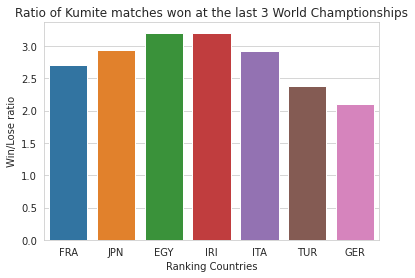

In [57]:
sns.set_style("whitegrid")
ax = sns.barplot(x='ranking_country',y='matches_won', data=senior_full_df)
ax.set(xlabel='Ranking Countries', ylabel='Win/Lose ratio')
ax.set_title('Ratio of Kumite matches won at the last 3 World Champtionships')
plt.show()

And then combine all the placements, with each one appropriately ranked.

In [59]:
senior_full_df = senior_full_df.drop(['matches_won'], axis=1)

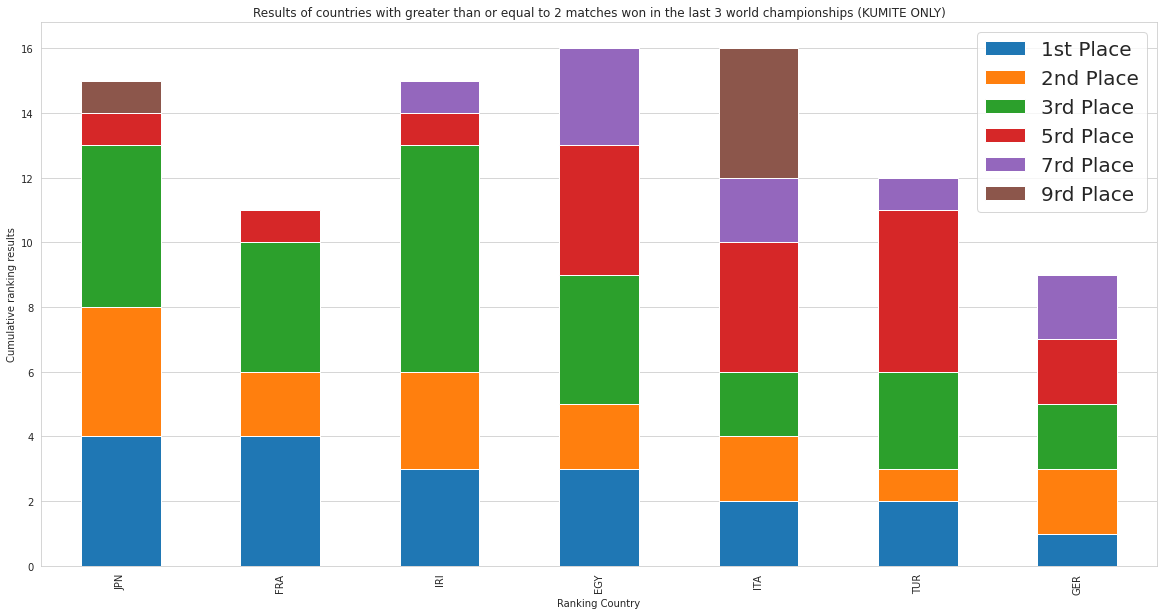

In [60]:
senior_full_df = senior_full_df.sort_values(['1st Place', '2nd Place', '3rd Place', '5rd Place', '7rd Place', '9rd Place'],
                                     ascending=[False, False, False, False, False, False])

senior_full_df.plot(x='ranking_country',
        kind='bar',
        stacked=True,
        title='Results of countries with greater than or equal to 2 matches won in the last 3 world championships (KUMITE ONLY)',
        figsize=(20,10)).grid(axis='x')
plt.xlabel('Ranking Country')
plt.ylabel('Cumulative ranking results')
plt.legend(fontsize=20)

So the top countries are Japan, France, Egypt, Iran, Turkey, Italy, Germany and Spain. These findings are based on the results of the last 3 world championships collectively.